In [1]:
#import plotly
#plotly.offline.init_notebook_mode()

## NB: This notebook makes use of *pyplot express* visualizations which allows for interactive hovering functionalities. However, because of Githubs storage limitations, the .ipynb version of this notebook only includes static .png versions of our plots. If possible, we recommend the reader to download the .html version of this notebook from our Github for the best experience.

# Explainer Notebook - Final Project
DTU - 02806  Social data analysis and visualization - 14/05/2021

Github: https://github.com/jacobsen100/social-data

Website: http://s152655.pythonanywhere.com/apps/blog_page

## 1. Motivation

### 1.1 Goal and purpose
*What was your goal for the end user's experience?*

The primary goal of this project is to facilitate a platform which enables a broad and detailed overview of the collision patterns in New York City (NYC). The end-product has resulted in a website in the genre of an interactive slideshow presented in different visualization tabs. The project has been created primarly with NYC Deparment of Transportation in mind, as it is belived they are the ones who could benefit the most from its insights of focal points of interest regarding crash vs. traffic-volume. However, regular curious users traversing the streets of NYC could also find value in the website as a predictive model also has been developed to predict the severity of your injuries in the case of you being a crash-victim, based on various demographic and external inputs. The purpose of this notebook is to present the throught-process and nitty gritty details, including the data analysis and associated visualizations, behind the scenery of the web application.

### 1.2 Datasets
*What is your dataset? Why did you choose this/these particular dataset(s)?*

To establish a good foundation of data for NYC collisions, we have chosen to collect data regarding; NYC collisions, NYC collision persons information, NYC traffic volume, and NYC weather. With this combination of data, we assess that a sound analysis of collision vs. traffic-volume patterns in NYC can be made. This is posssible based on a combined information pool of collisions and their respective longitude/lattitude, number of persons affected, affected persons' information, severity of injuries, weather conditions, and lastly traffic volume information. 


- **NYC Collision** <br /> "Motor_Vehicle_Collisions_-_Crashes.csv" <br />(https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) <br />  This dataset will function as our main dataset including informations regarding collisions in NYC from 2012 to present day. The dataset includes date- and time-stamps for the collisions, longitiude and lattitude of the collisions including specific roadway name and borough, and information of number motorists, cyclists, and pedestrians injured and/or killed in the related collision. Unique collision-ID's are also present to join the dataset to other relevant collision datasets from NYC OpenData. 
- **NYC Collision Person Information** <br /> "Motor_Vehicle_Collisions_-_Person.csv" <br /> (https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu) <br /> This dataset will function as additional information to the main collision dataset. By using the given unique collision-ID's, it is possible to join the two datasets. Relevant information from the dataset includes infromation regarding affected persons' age, gender, and injury status.
- **NYC Traffic Volume** <br /> "Traffic_Volume_Counts__2014-2019_.csv" <br /> (https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts-2014-2019-/ertz-hr4r) <br /> As mentioned before, NYC traffic volume information is required to establish a adequate foundation of analyzation by normalizing the collision data with the actual traffic volume of the affected NYC areas. The data quality of this dataset is not of the same level as the other NYC OpenData datasets, as there in many months are close to no observations given. However, this will be taken care of later in the notebook by relating the areal/time percentile distribtuions of the collisions with the areal/time percentile distributions of the volume against eachother. This dataset includes traffic volume from 2014-2019 by the number of vehicles on a given roadway name with related date- and timestamps.
- **NYC Weather** <br /> "Weather.csv" <br /> (https://www.ncdc.noaa.gov/cdo-web/datasets?fbclid=IwAR3y35cIg3wNO7oAAJJHyeLlwie5_eDaqcsoiKdh8tYjd_ldLhBm5fAJYtY#GHCND) <br /> This dataset has been chosen to be included as it is well-known that weather conditions could have an effect on the collision patterns. The dataset will be joined to the main collision dataset on the datestamp key. Relevant information from the dataset includes NYC weather conditions given by rain, fog, and snow on any given day. The dataset is not publically available and has been obtained by making a manual order-request to the National Centers for Environmental Information (NOAA).



## 2. Basic stats
*Let's understand the dataset better*

### 2.1 Data cleaning and preprocessing

#### 2.1.1 Libraries

In [2]:
# Loading neccesary packages
import pandas as pd
import numpy as np
from datetime import *
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import csv
import requests 
import joblib

from urllib.request import urlopen
import plotly.graph_objects as go
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
    
import warnings
warnings.filterwarnings('ignore')

#### 2.1.2 Crash dataset

This is considered our main dataset. NA's are not chosen to be replaced or removed as of yet, as this procedure depends on the various analyses to be made.

In [3]:
# Loading crash data
df_crash = pd.read_csv("Motor_Vehicle_Collisions_-_Crashes.csv") 

# Converting to datetime and adding hour-of-the-week column
df_crash['Date'] = pd.to_datetime(df_crash['CRASH DATE'])
df_crash['Time'] = pd.to_datetime(df_crash['CRASH TIME'])
df_crash['Hour_of_the_week'] = df_crash['Date'].dt.dayofweek * 24 + (df_crash['Time'].dt.hour + 1)

# Creating a broader dataset for further data descriptions
df_describe = df_crash[['NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED','BOROUGH','Date','COLLISION_ID']]
df_describe['Year'] = df_crash['Date'].dt.year

# Subsetting collision data
df_crash = df_crash[['COLLISION_ID','Hour_of_the_week', 'Date','CRASH DATE', 'Time', 'CRASH TIME','BOROUGH', 'ON STREET NAME', 'LATITUDE','LONGITUDE', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED']]

# Resulting in the following dataframe
df_crash.head()

,COLLISION_ID,Hour_of_the_week,Date,CRASH DATE,Time,CRASH TIME,BOROUGH,ON STREET NAME,LATITUDE,LONGITUDE,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED
0,4341417,159,2020-08-23,08/23/2020,2021-05-14 14:25:00,14:25,QUEENS,ROCKAWAY BOULEVARD,40.672382,-73.78574,0.0,1.0
1,4353423,62,2020-09-30,09/30/2020,2021-05-14 13:35:00,13:35,NaN,BELT PARKWAY,40.584250,-73.96380,0.0,1.0
2,4347736,95,2020-09-10,09/10/2020,2021-05-14 22:07:00,22:07,NaN,EAST 101 STREET,40.790417,-73.95184,0.0,0.0
3,4355042,17,2020-10-05,10/05/2020,2021-05-14 16:42:00,16:42,BRONX,BOSTON ROAD,40.838390,-73.88606,0.0,0.0
4,4342909,17,2020-08-24,08/24/2020,2021-05-14 16:08:00,16:08,BRONX,NaN,40.899517,-73.84716,0.0,1.0


#### 2.1.3 Traffic Volume dataset

Now, the traffic volume data is going to merged with the crash data based on the street name. This means, that every street name in the volume data also needs to be present in the crash data. To investigate this, the number of successfully and unsuccessfully merged street names are plotted below. The plot shows that 86 distinct roadway names in df_vol did not have match with df_crash. Therefore, a self-made .csv file was created where each of the 86 no-match roadway names where manually searched for in Google to associate a borough to it.

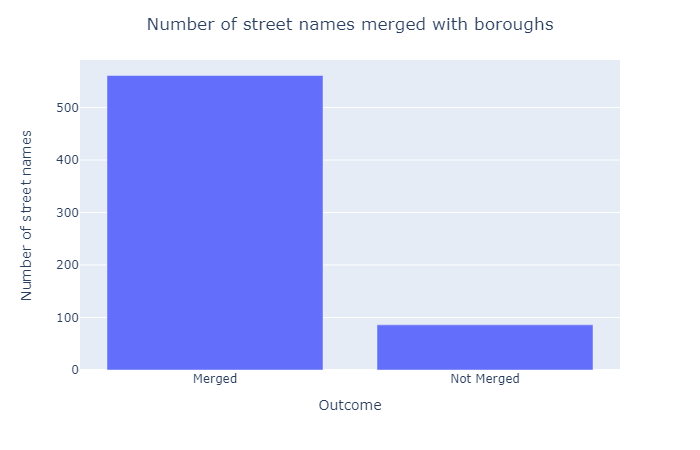

In [4]:
# Loading traffic volume data
df_vol = pd.read_csv("Traffic_Volume_Counts__2014-2019_.csv") 

# Loading traffic volume data
A = set(df_crash['ON STREET NAME'].str.strip().str.lower().unique()) # 7654 elements
B = set(df_vol['Roadway Name'].str.lower().unique()) #647 elements
correct = (len(A & B))
wrong = len([x for x in B if x not in A]) # 86 elements missing

df_correctborough = pd.DataFrame([correct,wrong]).rename(index={0:"Merged",1:"Not Merged"}, columns = {0:"Number of street names"}).reset_index().rename(columns={"index":"Outcome"})

fig = px.bar(df_correctborough,x="Outcome",y="Number of street names")
fig.update_layout(
    title = {"text": 'Number of street names merged with boroughs',"x":0.5,"xanchor":"center"},
)
fig.show("png")

In [5]:
# df_crash has no longitude/latitude, roadway, and borough given. However, df_vol dataset only includes Roadway Name.
# Therefore, to include Boroughs in df_vol, df_crash is left-joined on df_vol with the roadway as the key-column.

# Loading self-created dataset with missing roads to boroughs connections
df_roadborough = pd.read_csv("RoadToBoroughFix.csv", sep = ', ', engine='python')

# Preparing the two dataset for a left-join by stripping all whitespaces and making all characters lower-case
df_crash_join = pd.DataFrame() 
df_roadborough_join = pd.DataFrame() 

df_crash_join['BOROUGH'] = df_crash['BOROUGH']
df_roadborough_join['Borough'] = df_roadborough['Borough']

df_crash_join['ON STREET NAME'] = df_crash['ON STREET NAME'].str.strip().str.lower()
df_vol['Roadway Name'] = df_vol['Roadway Name'].str.lower()
df_roadborough_join['RoadName'] = df_roadborough['RoadName'].str.lower()

# Grouping by every distinct combination of Street + Borough including a count column 
df_crash_join = df_crash_join.groupby(['ON STREET NAME','BOROUGH']).size().reset_index(name='counts')

# In case of a road having multiple boroughs, keep the borough with the most occurences
df_crash_join = df_crash_join.sort_values('counts').drop_duplicates('ON STREET NAME',keep='last')

# Left joining the crash-data with the road as key, adding the BOROUGH column to the volume data
df_merged1 = pd.merge(df_vol, df_crash_join[['ON STREET NAME','BOROUGH']], how='left', left_on='Roadway Name', right_on='ON STREET NAME')
# Left joining the self-made road to borough data on all roads without a BOROUGH on the merged data frame.
df_merged2 = pd.merge(df_merged1, df_roadborough_join[['RoadName','Borough']], how='left', left_on='Roadway Name', right_on='RoadName')

# Melting the two borough columns from df_crash and df_roadborough
df_merged2['BOROUGH'].update(df_merged2.pop('Borough'))

# Removing redundant columns
df_merged2 = df_merged2.iloc[:, np.r_[32,6,7:31]]

# Resulting in the following dataframe
df_merged2.head()

,BOROUGH,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,3:00-4:00AM,4:00-5:00AM,5:00-6:00AM,6:00-7:00AM,7:00-8:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,MANHATTAN,09/13/2014,204.0,177.0,133.0,126.0,141.0,134.0,121.0,180.0,...,520,611,573,546,582,528,432,328,282,240
1,MANHATTAN,09/13/2014,140.0,51.0,128.0,116.0,144.0,146.0,153.0,219.0,...,379,376,329,362,418,335,282,247,237,191
2,BRONX,09/13/2014,94.0,73.0,65.0,61.0,64.0,73.0,65.0,113.0,...,280,272,264,236,213,190,199,183,147,103
3,BRONX,09/13/2014,88.0,82.0,75.0,60.0,65.0,67.0,71.0,142.0,...,237,276,223,240,217,198,186,162,157,103
4,MANHATTAN,09/13/2014,255.0,209.0,149.0,148.0,128.0,136.0,199.0,354.0,...,732,809,707,675,641,556,546,465,425,324


In [6]:
# Using the .melt function to go from a colulmn based "hour interval" to a row based one instead.
# This has to be done for future use with other data frames in the same format.
# This will essentially result in 24 times more rows than in the original df_merge.
df_merged2 = df_merged2.melt(id_vars=["BOROUGH","Date"], 
        var_name="Time", 
        value_name="Value")

# Transforming the Date: "09/13/2014" Time: "12:00-1:00 AM" format to the following: "09-13-2014 00:59:00"
df_merged2['Time'] = df_merged2['Time'].str.replace(' ', '')
df_merged2['TimeNew'] = df_merged2['Time'].astype(str).str[-7:]
df_merged2['TimeNew'] = df_merged2['TimeNew'].str.replace('-', '')

df_merged2['TimeFinal'] = df_merged2['Date'] + ' ' + df_merged2['TimeNew']
df_merged2['TimeFinal'] = pd.to_datetime(df_merged2['TimeFinal'])

one_minute = timedelta(minutes=1)
df_merged2['TimeFinal'] = df_merged2['TimeFinal'] - one_minute
df_merged2['Hour'] = df_merged2['TimeFinal'].dt.hour

# Adding a hour-of-the-week column
df_merged2['hour_of_the_week'] = df_merged2['TimeFinal'].dt.dayofweek * 24 + (df_merged2['TimeFinal'].dt.hour + 1)

# Resulting in the following dataframe
df_merged2.head()

,BOROUGH,Date,Time,Value,TimeNew,TimeFinal,Hour,hour_of_the_week
0,MANHATTAN,09/13/2014,12:00-1:00AM,204.0,1:00AM,2014-09-13 00:59:00,0,121
1,MANHATTAN,09/13/2014,12:00-1:00AM,140.0,1:00AM,2014-09-13 00:59:00,0,121
2,BRONX,09/13/2014,12:00-1:00AM,94.0,1:00AM,2014-09-13 00:59:00,0,121
3,BRONX,09/13/2014,12:00-1:00AM,88.0,1:00AM,2014-09-13 00:59:00,0,121
4,MANHATTAN,09/13/2014,12:00-1:00AM,255.0,1:00AM,2014-09-13 00:59:00,0,121


#### 2.1.4 New York Weather dataset

First, the number of NA's are investigated. We are mainly going to use the indications of whether a weather condition is present or not, so only the number of NA's for these variables are shown below. The weather conditions have a very high number of NA observations compared to the number of observations. We assume that a weather condition is not present when containing a NA value, thus the weather conditions are filled with 0 if that weather condition is not present. In some instances, there are even observations where a certian amount of precipitation have been observed, but that the weather condition is not noted. Therefore, if any amount of for example precipitation or snow has been observed, we consider that weather condition to have been present on that day.

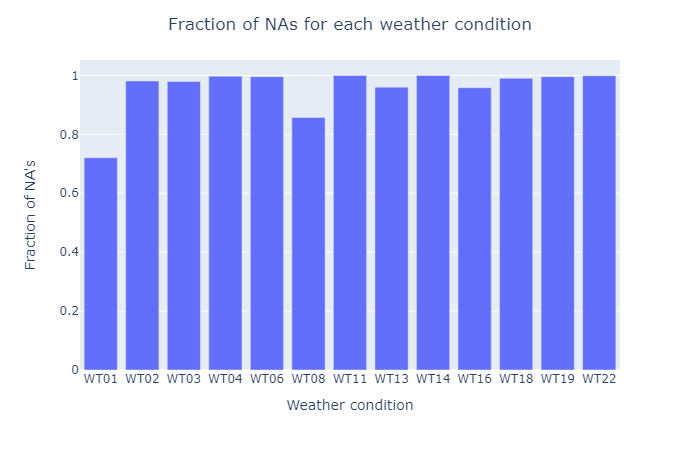

In [7]:
# Loading weather data
df_weather =  pd.read_csv("Weather.csv")

df_weather_na = df_weather.isnull().sum().iloc[21:39]/len(df_weather)
fig = px.bar(df_weather_na)
fig.update_layout(title = {"text": 'Fraction of NAs for each weather condition',"x":0.5,"xanchor":"center"}, xaxis_title='Weather condition',yaxis_title="Fraction of NA's", showlegend = False)
fig.show("png")

In [8]:
# Filling NA's with 0's
df_weather = df_weather.fillna(0)

# Converting to datetime
df_weather['Date'] = pd.to_datetime(df_weather['DATE'])

# Subsetting weather data.
# PRCP is Perception, and WT16 is a binary value indicating if it rains or not
# SNOW is the snow perception, SNWD is the thickness of the snow on the ground
# and WT18 is a binary value indicating if it snows or not
# WT01 is a binary value indicating if it snows or not

df_weather = df_weather[['Date','PRCP', 'WT16', 'SNOW', 'SNWD', 'WT18', 'WT01']]

df_weather['Fog'] = df_weather['WT01']
#If just one of the following is present, indicate a 1 in Rain
df_weather['Rain'] = df_weather['PRCP'] + df_weather['WT16']
df_weather['Rain'].values[df_weather['Rain'] > 0] = 1
#If just one of the following is present, indicate a 1 in Snow
df_weather['Snow'] = df_weather['SNOW'] + df_weather['SNWD'] + df_weather['WT18']
df_weather['Snow'].values[df_weather['Snow'] > 0] = 1

# Observations are based on a daily basis. There are instances where the same day appears more than once
# Therefore, the observation with the most relevant information is kept.
# Relevant columns for the further analysis are chosen to be; WT01 = Fog, WT16 = Rain, WT18 = Snow,
df_weather['sum'] = df_weather['Fog'] + df_weather['Rain'] + df_weather['Snow']
df_weather = df_weather.sort_values('sum').drop_duplicates('Date',keep='last')

# Subsetting weather data
df_weather = df_weather[['Date','Fog','Rain','Snow']]

# Resulting in the following dataframe
df_weather.head()

,Date,Fog,Rain,Snow
USW00094728,2017-08-06,0.0,0.0,0.0
USW00094728,2018-06-29,0.0,0.0,0.0
USW00094728,2018-06-30,0.0,0.0,0.0
USW00094728,2018-07-01,0.0,0.0,0.0
USW00094728,2018-07-02,0.0,0.0,0.0


####  2.1.5 Affected Persons Information dataset

First, to get an idea of the data quality regarding the ages, the number of persons dependent on age is plotted below. The plot shows that there are problems with this attribute. There are few unrealistic high and low ages, for example people with negative ages and ages above thousands. Also, there are 500.000 persons with an age of 0. On this basis, persons with an age below 1 and above 100 are replaceed with NA values in the age attribute.

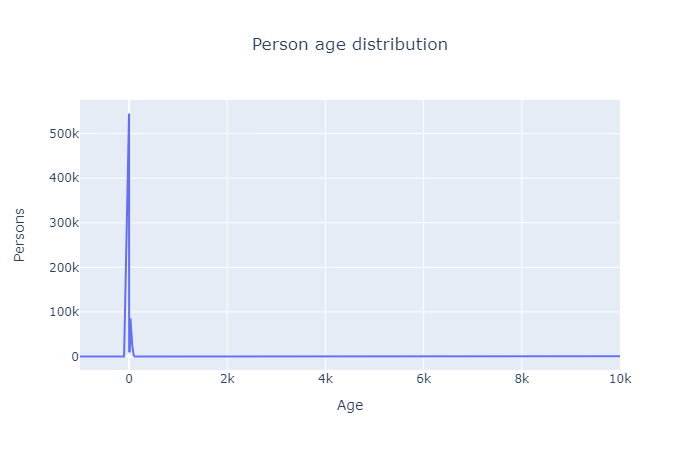

In [9]:
# Loading persons data
df_persons =  pd.read_csv("Persons.csv")

df_age_plot= df_persons.groupby(['PERSON_AGE']).count().reset_index().rename(columns={'COLLISION_ID': 'Persons'})
fig = px.line(df_age_plot, x="PERSON_AGE", y="Persons", title="Ages of persons")
fig.update_layout(
   xaxis_title="Age",title = {"text": 'Person age distribution',"x":0.5,"xanchor":"center"} 
)

fig.show("png")

In [10]:
# Instances where persons are younger than 1 years and older than 100 years are estimated to be data errors
df_persons['PERSON_AGE'] = np.where(df_persons['PERSON_AGE'] > 100, None, df_persons['PERSON_AGE'])
df_persons['PERSON_AGE'] = np.where(df_persons['PERSON_AGE'] < 1, None, df_persons['PERSON_AGE'])

# Subsetting persons data
df_persons = df_persons[['COLLISION_ID','PERSON_TYPE','PERSON_INJURY','PERSON_AGE','PERSON_SEX']]

### 2.2 Creating Crash/Volume Metric
*Procedure of creating the crash/volume metric for future analysis application*

Since the time/date is the primary key of joining the crash and volume data together, we will explore if the volume data has a sound fondation of data. A plot has been visualized below, which shows the number of roads measured for volume in each month. It can be clearly seen, that the data is lacking in many of the months across the years. Therefore, it is not sufficient to simply join the two data-sets on their dates. Instead, we will go through a procedure where we compress the time/dates into hour-of-the-week, and thereby enabeling a way to compare the crash data with the volume data.

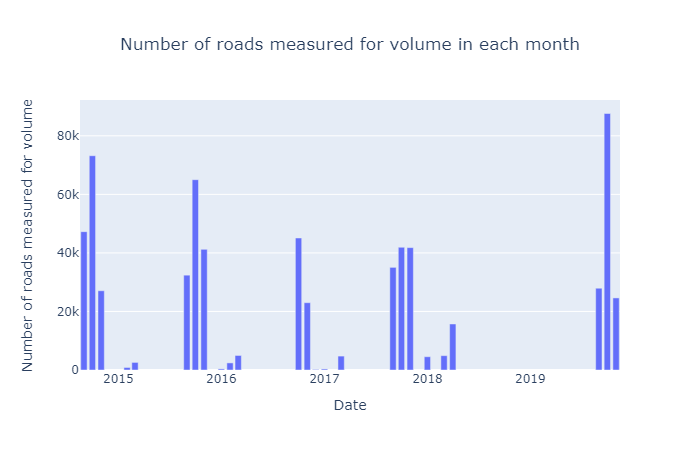

In [11]:
df_merged2['Date1'] = pd.to_datetime(df_merged2['Date']).dt.strftime('%Y-%m')
fig = px.bar(df_merged2.groupby('Date1').count().reset_index(),x="Date1", y="BOROUGH",  title="Number of roads measured for volume in each month")
fig.update_layout(yaxis_title="Number of roads measured for volume", xaxis_title="Date", title = {"text": 'Number of roads measured for volume in each month',"x":0.5,"xanchor":"center"})
fig.show("png")

The challenge here is therefore to create a crash/volume metric based on the information we have available. To do this, we've created a procedure where we look isolated at the fractions for df_crash and df_vol respectively. So, the idea is to instead of looking at the raw count of the volume data for each date, we instead look at the percentile distribution given in any given hour-of-the-week for any given borough. This is of course made on the assumption that the data currently available shows realistic patterns of traffic volumes in NYC, which will be explored further in the Data Analysis part (Spoiler: It actually shows very good results). The same procedure is then made for the df_crash data, so we then will be able to compare the fraction of crashes with the fraction of volume in any given hour-of-the-week for any borough. 

It is important to note, that while we are certian that the df_crash is of high quality, we are not sure how many traffic volume counters have been distributed across NYC. We therefore risk that a borough with many traffic counters will appear as more populated than boroughs with less traffic counters. To solve this problem, we have grouped the volume data by taking the average traffic volume in each seperate borough for any given hour-of-the-week. This problem is not apperant in the df_crash data, why we here group the data by simply counting the number of observations in each seperate borough for any given hour-of-the-week. While this whole procedure may seem convoluted, it has shown very promising results that allow us to actually compare the NYC crashes with the traffic volume.

In [12]:
# Preparing the crash data.Firstly Removing redundant columns
df_crash_metric = df_crash[['BOROUGH','CRASH DATE','CRASH TIME']]

# Appending the date and time column
df_crash_metric['TimeFinal'] = df_crash_metric['CRASH DATE'] + ' ' + df_crash_metric['CRASH TIME']
df_crash_metric['TimeFinal'] = pd.to_datetime(df_crash_metric['TimeFinal'])

df_crash_metric['Hour'] = df_crash_metric['TimeFinal'].dt.hour

# Adding a hour-of-the-week column
df_crash_metric['hour_of_the_week'] = df_crash_metric['TimeFinal'].dt.dayofweek * 24 + (df_crash_metric['TimeFinal'].dt.hour + 1)

# Grouping by hour of the week for crash (counting while grouping)
df_crash_groupHourWeek = df_crash_metric[['BOROUGH', 'hour_of_the_week','TimeFinal']].groupby(by=['BOROUGH', 'hour_of_the_week']).count()

# Grouping by hour of the week for colume (mean while grouping)
df_vol_groupHourWeek = df_merged2[['BOROUGH', 'hour_of_the_week','Value']].groupby(by=['BOROUGH', 'hour_of_the_week']).mean()

In [13]:
# Creating new dataframes with the distribution fractions described above
df_crash_groupHourWeek['Percentage'] = df_crash_groupHourWeek['TimeFinal']/df_crash_groupHourWeek.sum().values
df_crash_groupHourWeek = df_crash_groupHourWeek.rename(columns = {'TimeFinal': 'Crash_Count'}, inplace = False)
df_vol_groupHourWeek['Percentage'] = df_vol_groupHourWeek['Value']/df_vol_groupHourWeek.sum().values
df_vol_groupHourWeek = df_vol_groupHourWeek.rename(columns = {'Value': 'Vol_Mean'}, inplace = False)

In [14]:
print("Crash distribution fractions")
display(df_crash_groupHourWeek)

Crash distribution fractions


Crash_Count  Percentage
BOROUGH       hour_of_the_week                         
BRONX         1                         727    0.000593
              2                         351    0.000286
              3                         232    0.000189
              4                         223    0.000182
              5                         262    0.000214
...                                     ...         ...
STATEN ISLAND 164                       266    0.000217
              165                       247    0.000202
              166                       233    0.000190
              167                       174    0.000142
              168                       133    0.000109

[840 rows x 2 columns]

In [15]:
print("Volume distribution fractions")
display(df_vol_groupHourWeek)

Volume distribution fractions


Vol_Mean  Percentage
BOROUGH       hour_of_the_week                        
BRONX         1                 190.402961    0.000444
              2                 125.481908    0.000292
              3                  97.014803    0.000226
              4                  94.690789    0.000221
              5                 145.092105    0.000338
...                                    ...         ...
STATEN ISLAND 164               509.428218    0.001187
              165               431.846535    0.001006
              166               334.027228    0.000778
              167               262.482673    0.000612
              168               188.861386    0.000440

[840 rows x 2 columns]

This now leads us to the actual calculation of the crash/volume metric. The metric is given by:

$$\frac{\text{Crash_Percentage}}{\text{Volume_Precentage}} = \text{Crash/Volume ratio}$$

This means, that if the Crash/Volume ratio is greater than 1, then the fraction of crashes compared to all other crashes in that hour is larger than the fraction of traffic volume compared to all other traffic volumes in that hour, and vice-versa if the value is less than 1. This leaves us with a usable ratio that now considers the number of crashes in relation to the traffic volume, and that can be used to analyse which boroughs are the most dangerous.

In [16]:
# Creating the final dataframe, where we divide the percentile crashes with the percentile volumne.
# So the greater a value is than 1, the more dangours that specefic borough+hour combination is.
df_ratio = pd.merge(df_crash_groupHourWeek.reset_index(level=[0]),df_vol_groupHourWeek.reset_index(level=[0]), on=['BOROUGH','hour_of_the_week'])
df_ratio = df_ratio.reset_index(level=[0])
df_ratio = df_ratio.rename(columns = {'Percentage_x': 'Percentage_Crash', 'Percentage_y': 'Percentage_Volume'}, inplace = False)
df_ratio["Crash/Volume Ratio"] = df_ratio['Percentage_Crash']/df_ratio['Percentage_Volume']
df_ratio.head()

,hour_of_the_week,BOROUGH,Crash_Count,Percentage_Crash,Vol_Mean,Percentage_Volume,Crash/Volume Ratio
0,1,BRONX,727,0.000593,190.402961,0.000444,1.336601
1,2,BRONX,351,0.000286,125.481908,0.000292,0.979190
2,3,BRONX,232,0.000189,97.014803,0.000226,0.837127
3,4,BRONX,223,0.000182,94.690789,0.000221,0.824401
4,5,BRONX,262,0.000214,145.092105,0.000338,0.632119


### 2.3 Exploratory data analysis
*Discussion of the dataset stats*

Instead of writing distinct exploratory sections for each of our point of interests; Time dependent crash patterns, Crash vs. traffic volume patterns, Crash severity, Boroughs, Demographics, and Weather, we have instead chosen to combine the exploratory data analysis for each of these parts with each of their explanatory analysis in the Data analysis part below.

## 3. Data analysis and machine learning predictive model
*Describe your data analysis and explain what you've learned about the dataset. Talk about your machine-learning.*

In this section, we firstly want to explore and explain the following topics from our above created data; Crash vs. traffic volume patterns, Crash severity, Boroughs, Demographics, and Weather. Main observations and discussions will be explicitly written above each visualization.

Then, we will go through our Random Forest machine learning predictive model, which aims to predict injury sevirety given on the assumption that a person has been a victim of a crash based on various demographic and external factors. The following parts will be covered; data balancing and one hot encoding, choise of model, measuring recall and precission for each class, hyper parameter tuning through grid-search, and finally feature importance.

### 3.1 Data analysis

#### 3.1.1 Time dependent crash patterns

The plot below shows how the number of crashes has developed throghout the time of the dataset. The number of crashes seems to be increasing from around 170.000 crashes in 2013 to its peak in 2017 and 2018 where the number of crashes was around 220.000. The effect of corona is clearly seen in the drop of crashes in 2020, as it has almost halved since 2019, indicating that the traffic has decreased in 2020. The dataset starts mid 2012 and ends in April 2021, which explains the low number of crashes these years. For simplicity, observations before 2013 and after 2020 will no be shown in the next visualisation. However, the observations will not be removed from the dataset as they can still be valuable for any analysis on a lower level without yearly considerations.

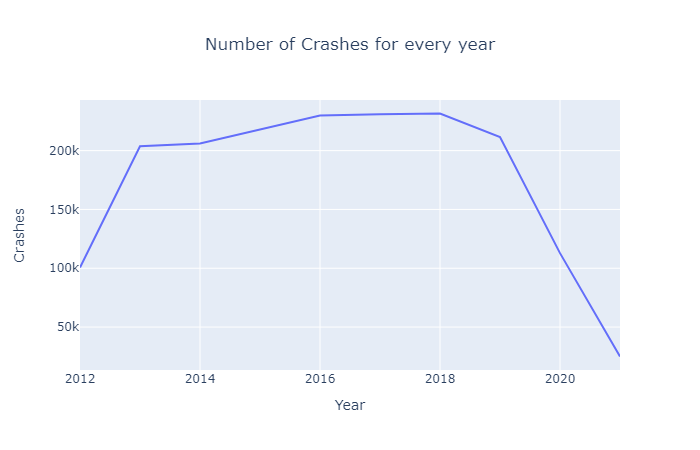

In [17]:
yearplot= pd.DataFrame(df_describe.groupby('Year').count()['COLLISION_ID']).reset_index().rename(columns={'COLLISION_ID': 'Crashes'})

fig = px.line(yearplot, x="Year", y="Crashes",  title="Number of Crashes for every year")

fig.update_layout(title={"x":0.5})

fig.show("png")

The below plot consists of two y-axes due to the difference in scale, thus the left axis shows the number of injured persons, while the right axis shows the number of killed persons. The plot shows that the number of injured and killed persons involved in a crash has more or less the same trend, with some minor deviations. The previously mentioned effect from corona is seen in the number of injured persons, as this is at the lowest level in the entire period. The number of killed persons, however, are acutally at the second highest level in 2020, thus not being effected by the lower number of crashes.

C:\Users\jonat\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:329: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.


C:\Users\jonat\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




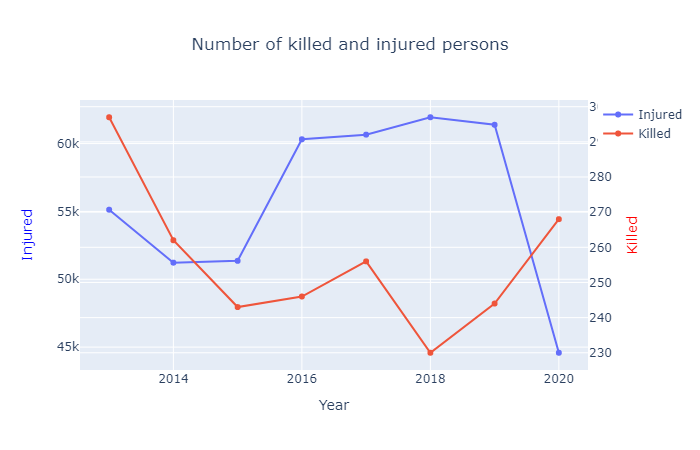

In [18]:
injuryplot=df_describe.groupby('Year').sum().reset_index()[:-1].iloc[1:]

data = [
    go.Scatter(x = injuryplot['Year'], y=injuryplot["NUMBER OF PERSONS INJURED"], name='Injured'),

    go.Scatter(x = injuryplot['Year'], y=injuryplot["NUMBER OF PERSONS KILLED"], name='Killed', 
                yaxis='y2') # binding to the second y axis
]

# settings for the new y axis

y1 = go.YAxis(title='Injured', titlefont=go.Font(color='Blue'))
y2 = go.YAxis(title= 'Killed', titlefont=go.Font(color='Red'))

y2.update(overlaying='y', side='right')
# adding the second y axis
layout = go.Layout(yaxis1 = y1, yaxis2 = y2)

fig = go.Figure(data=data, layout=layout)
fig.update_layout( title={'text':"Number of killed and injured persons",'x':0.5, 'xanchor': 'center'},
                  xaxis_title='Year'
)
fig.show("png")

The following plot part will investigate how the time of the day affects the number of crashes, starting by plotting the crashes depending time of the day. The below plot shows the percentage of total crashes throughout the day. The lowest number of crashes are at night, where the minimum is between the time 03:00-04:00 with only 1% of the total number of crashes. From this point, the number of crashes is increasing with a local peak at the morning rush hour, and global peak around the afternoon rush hour.

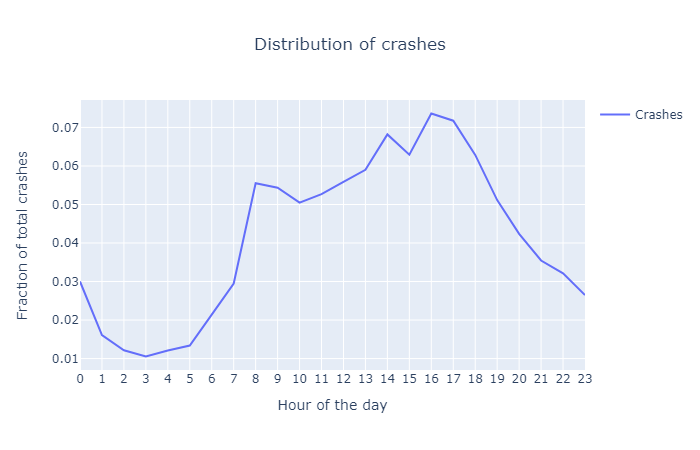

In [19]:
x=pd.DataFrame(df_crash['Time'].groupby(df_crash['Time'].dt.hour).count()/len(df_crash)).rename(columns={'Time':'Crashes'})
fig = px.line(x, title="Distribution of crashes", labels = {"variable":""})
fig.update_layout( xaxis = dict(
        tickvals = np.linspace(0,23,24)),
    xaxis_title='Hour of the day',yaxis_title="Fraction of total crashes",title = {"x":0.5,"xanchor":"center"}
)
fig.show("png")

To show a more nuanced view, the traffic volume is now included in the analysis of the following part.

#### 3.1.2 Time depended crash vs. traffic volume patterns

The below plot shows volume and crashes plotted for every hour throughout a whole week. It shows that the volume and crash percentages follow each other quite well. In the weekdays, the volume has two peak points, at the morning and afternoon rush hour. This makes good sense, as this is the time where the traffic is affected by people going to and home from work. The pattern is a little different in the weekend, as there is only one peak point in the afternoon, as this is the time people for example are going out to enjoy the city. The volume are also a bit lower at the weekend, due to fewer people are going to work. The same patterns are seen in the crashes, however, the crashes has some higher peak points. This shows that there is relative more crashes compared to the traffic volume at the peak points, and vice versa at the other times of the day. This plot also confirms that our method of comparing the crash data to the volume data actually has worked out very well.

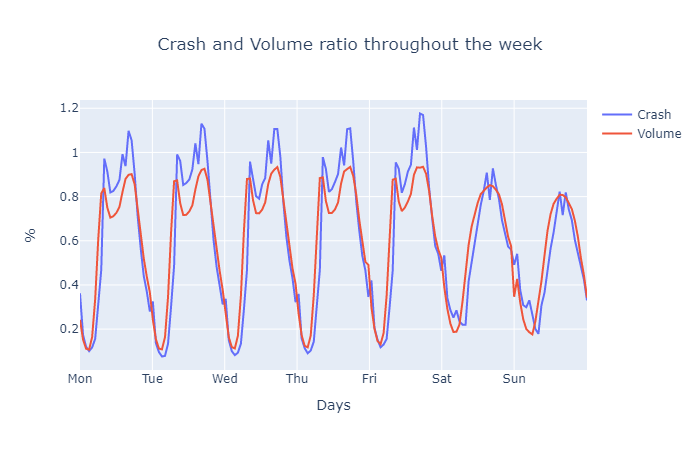

In [20]:
# Plotting traffic and crash percentage over the week

df_ratio['FIPS'] = df_ratio['BOROUGH'].apply(lambda x: '36005' if x == "BRONX" else '36047' if x == "BROOKLYN" else '36061' if x == "MANHATTAN" else  '36081' if x == "QUEENS" else '36085' if x == "STATEN ISLAND" else "No Borough")

weekday=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

percentage_plot= (df_ratio.groupby('hour_of_the_week').sum()*100).reset_index().rename(columns={"Percentage_Crash":"Crash","Percentage_Volume":"Volume"})
fig = px.line(percentage_plot, x="hour_of_the_week", y=["Crash",'Volume'], title="Crash and Volume ratio throughout the week", labels = {"variable":""})
fig.update_layout(
    xaxis = dict(
        tickvals = np.linspace(1,168-24,7),
        ticktext = weekday
    )
    ,xaxis_title='Days',yaxis_title="%",
    title={'x':0.5, 'xanchor': 'center'},
    
    
)
fig.show("png")

The next part will investigate the severity of crashes.

#### 3.1.3 Crash severity

The frequency of being either injured or killed when involved in a crash is visualised in the plot below. The plot shows that a motorist is injured in around 20% of the crashes, thus this group has the highest probability of getting injured, while a pedestrian and cyclist are injured in respectively 5% and 2.5% of the crashes. 0.067% of the pedestrians are killed in a crash, making them the most frequent group to suffer death when being involved in a crash. This means that a pedestrian is killed in one out of 1500 crashes.

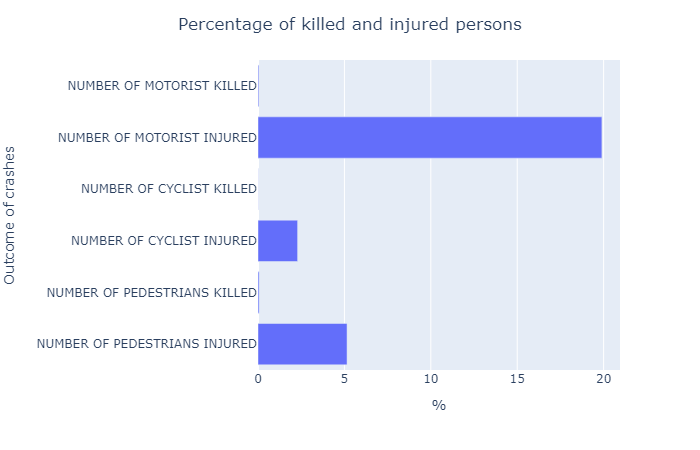

In [21]:
means=pd.DataFrame((round(df_describe.describe(),5).loc['mean'][2:8]*100)).reset_index().rename(columns={"index":"Outcome"})

fig = px.bar(means, y="Outcome", x="mean",orientation="h")
fig.update_layout(
    xaxis_title='%',yaxis_title="Outcome of crashes",
    title={
        'text': "Percentage of killed and injured persons",
        'x':.5}
)
fig.show("png")

 In the following section, the number of crashes for the different boroughs will be investigated.

#### 3.1.4 Boroughs

The boxplot below shows the number of crashes on a daily basis given for each borough. Brooklyn has the highest median value of crashes, with a daily number of crashes of 124. This is also the borough with the highest number of crashes on a single day, with 254 crashes. Staten Island seems to have the lowest number of crashes, with a median value of 16, thus having a median value ~8 times lower compared to Brooklyn. However, as discussed before, the crash data is more valuable combined with the traffic volume data which will be explored next.

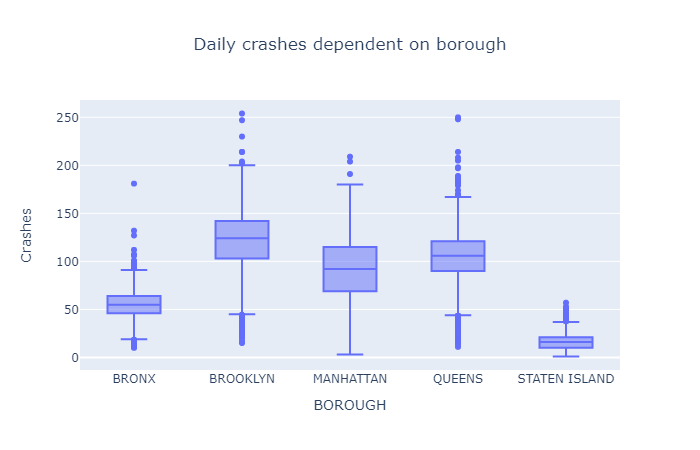

In [22]:
boroughplot= df_crash.groupby(['BOROUGH','Date']).count().reset_index()[['BOROUGH','COLLISION_ID']].reset_index().rename(columns={"COLLISION_ID":"Crashes"})
fig = px.box(boroughplot, x="BOROUGH",y="Crashes", title='Daily crashes dependent on borough')
fig.update_layout(title={'x':0.5, 'xanchor': 'center'})
fig.show("png")

Below, a bar chart has been made to show which boroughs are most dangerous based on their crash/volume ratio. Brooklyn and Queens are the boroughs with a crash/volume ratio above 1, which means that there is relatively more crashes in these boroughs compared to their traffic volume. Brooklyn is by far the most dangeorous borough as it has a ratio around 2. Staten Island has a crash/volume around 0.25, which makes it the most safe borough.

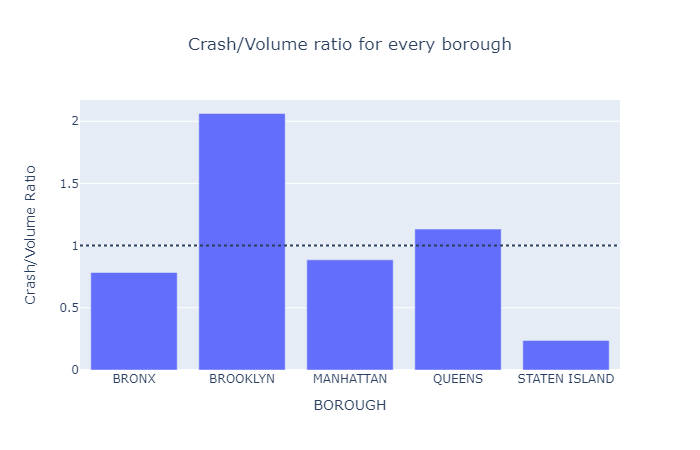

In [23]:
# Plotting the crash/volume ratio for every borough 

df_ratios_plot = df_ratio.groupby("BOROUGH").mean().reset_index()
fig = px.bar(df_ratios_plot, x="BOROUGH", y="Crash/Volume Ratio",barmode='group', title='Crash/Volume ratio for every borough')
fig.update_layout(title={'x':0.5, 'xanchor': 'center'})
fig.add_hline(y=1, line_dash="dot")
fig.show("png")

To investigate the above patterns further, the crash/volume ratio is plotted througout the week for all the five boroughs below. The crash/volume ratio has the same patterns in all the boroughs but with different scales. Brooklyn has the highest crash/volume ratio throughout the whole period, with its peak point around 5 AM sunday morning, with a value around 3.5. This is the peak point for all the boroughs. A reason for this could be that the volume is rather low at this point, thus crashes has an great impact in the crash ratio. Furthermore, drunk driving and people being tired in the middle of the night are also factors that could increase the number of crashes compared to the volume.

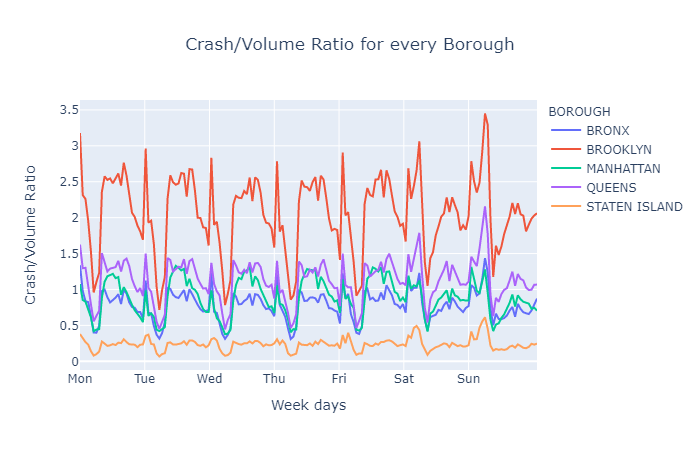

In [24]:
# Plotting crash/ratio for every borough over the week

fig = px.line(df_ratio, x="hour_of_the_week", y="Crash/Volume Ratio", color="BOROUGH", title="Crash/Volume Ratio for every Borough")
fig.update_layout(
    xaxis = dict(
        tickvals = np.linspace(1,167-24,7),
        ticktext = weekday
    )
    ,xaxis_title='Week days',yaxis_title="Crash/Volume Ratio", title={'x':0.5, 'xanchor': 'center'}
)
fig.show("png")

 In the next section, the demographic properties of the crash victims will be investigated.

#### 3.1.5 Demographics

Below, a bar plot has been created that shows the number of crashes distributed across the genders. It is seen that males are by far the gender which is involved in the most crashes, as they are involved in almost twice as many crashes compared to females.

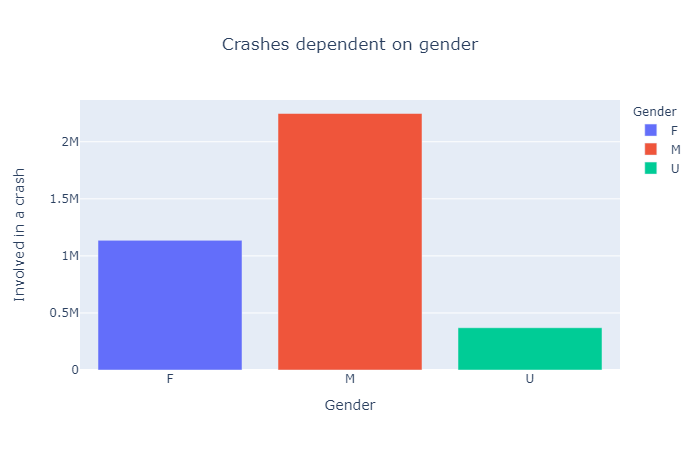

In [25]:
# Plotting the number of crashes for every Gender

df_gender= df_persons.groupby(['PERSON_SEX']).count().reset_index()
fig = px.bar(df_gender, x="PERSON_SEX", y="PERSON_INJURY",title="Crashes dependent on gender",color='PERSON_SEX',labels={
                     "PERSON_SEX": "Gender"
                 })
fig.update_layout(
    xaxis_title='Gender',yaxis_title="Involved in a crash", title={'x':0.5, 'xanchor': 'center'}
)
fig.show("png")

A person's age would also be interesting to look at. Below, the number crashes dependent on both age and gender has been visualized. The plot shows that the number of crashes is on a steady level in the range between 0 to 16. Until the age of 16, a person is not allowed to have a driving license, which is clearly seen in the plot. The number of crashes has an increasing trend from this point and until the person is 30 years old, which is the peak point for the each gender isolated. The reason for this trend could be that the drivers are young and unexperienced, thus being involved in more crashes.

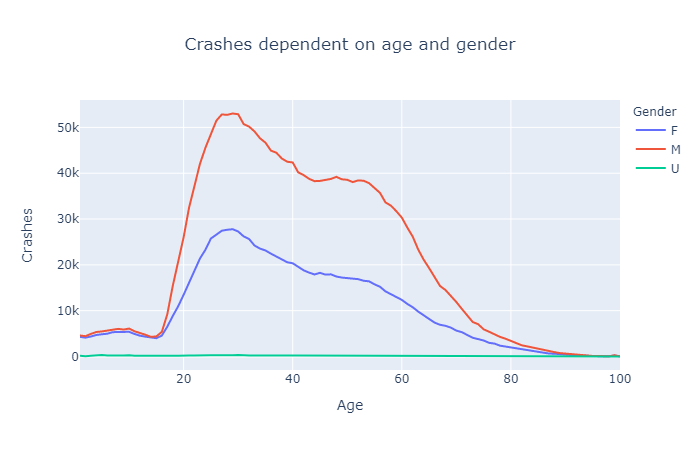

In [26]:
# Plotting the number of crashes for every sex dependent on ange

df_age_sex= df_persons.groupby(['PERSON_AGE','PERSON_SEX']).count().reset_index().rename(columns={'COLLISION_ID': 'Crashes'})

fig = px.line(df_age_sex, x="PERSON_AGE", y="Crashes", color='PERSON_SEX', title="Crashes dependent on age and gender", labels={
                     "PERSON_SEX": "Gender"
                 })

fig.update_layout(
   xaxis_title="Age", title={'x':0.5, 'xanchor': 'center'}
)



fig.show("png")

Lastly for the Data Analysis, the weather conditions effect on the crashes will be explored in the following section.

#### 3.1.6 Weather

The plot below shows the occurences of each selected weather condition in the dataset. It is seen that the most frequent weather condition is clear (no rain, fog, or snow). The number of rainy and foggy days are quite equal, while snowing is the most rare weather condition.

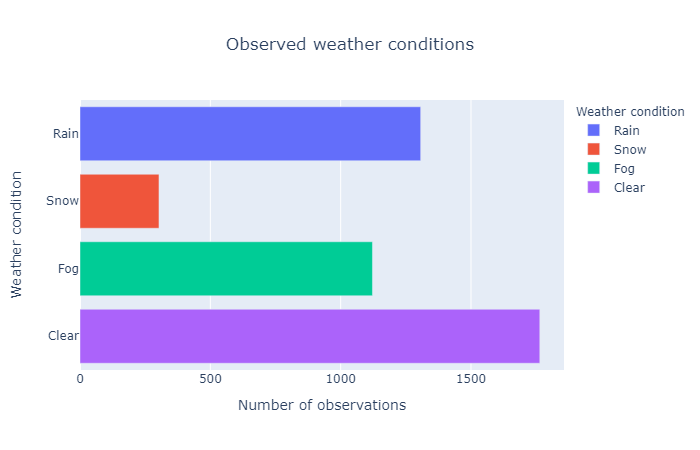

In [27]:
rain = sum(df_weather['Rain'])
snow= sum(df_weather['Snow'])
fog=sum(df_weather['Fog'])
clear = len(df_weather[(df_weather['Fog']==0)&(df_weather['Rain']==0)&(df_weather['Snow']==0)])

X = pd.DataFrame([rain,snow,fog,clear]).reset_index().rename(columns={'index': "Weather condition",0:"Number of days"}).replace({0: "Rain", 1: "Snow",2:"Fog",3:"Clear"}, inplace=False)
fig = px.bar(X, y='Weather condition',x="Number of days",title="Observed weather conditions",color="Weather condition")
fig.update_layout(
    xaxis_title='Number of observations',yaxis_title="Weather condition",
title={'x':0.5, 'xanchor': 'center'})
fig.show("png")

To investigate the weather conditions further, the number of daily crashes is plotted next. The plot below shows the average number of crashes on a daily basis, if it is raining, snowing, foggy, or clear. The weather condition with the most crashes is when there is fog, which has an impact on the visibility for the drivers. Snow actually have a lower number of crashes, compared to when none of the weather conditions are present. This could be explained by the idea that people are more aware of the dangers of driving in the snow, while underestimating the dangers of rain and fog, thus driving more carefully in the snow.

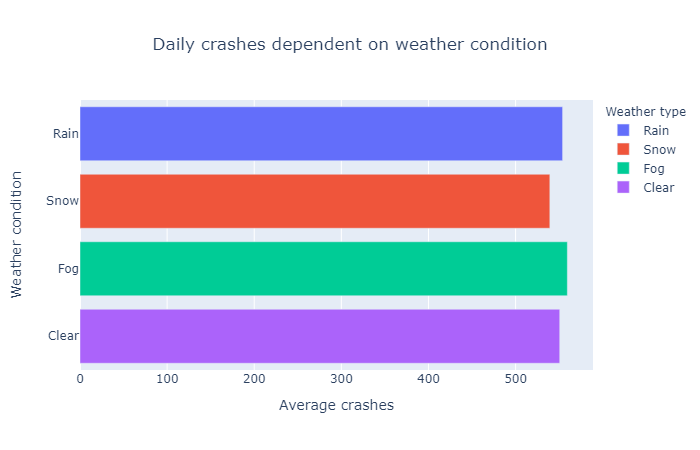

In [28]:
df_weather_plot = pd.merge(df_crash, df_weather,  how='left', left_on=['Date'], right_on = ['Date'])
rain = len(df_weather_plot[df_weather_plot['Rain']==1])/len(df_weather_plot[df_weather_plot['Rain']==1]['Date'].unique())
snow= len(df_weather_plot[df_weather_plot['Snow']==1])/len(df_weather_plot[df_weather_plot['Snow']==1]['Date'].unique())
fog=len(df_weather_plot[df_weather_plot['Fog']==1])/len(df_weather_plot[df_weather_plot['Fog']==1]['Date'].unique())
clear = len(df_weather_plot[(df_weather_plot["Fog"]==0) & (df_weather_plot["Rain"]==0) & (df_weather_plot["Snow"]==0) ])/len(df_weather_plot[(df_weather_plot["Fog"]==0) & (df_weather_plot["Rain"]==0) & (df_weather_plot["Snow"]==0) ]['Date'].unique())
X = pd.DataFrame([rain,snow,fog,clear]).reset_index().rename(columns={'index': "Weather type",0:"Average Crashes"}).replace({0: "Rain", 1: "Snow",2:"Fog",3:"Clear"}, inplace=False)
fig = px.bar(X, y='Weather type',x="Average Crashes",color="Weather type",title="Daily crashes dependent on weather condition",orientation ="h")
fig.update_layout(
    xaxis_title='Average crashes',yaxis_title="Weather condition",
title={'x':0.5, 'xanchor': 'center'})
fig.show("png")

### 3.2 Machine Learning - Crash severity prediction

In this part of the notebook, a model to predict the person injury outcome of a crash will be established. The model should predict the outcome to be either unharmed or injury, based on several attributes. These attributes are listed below:
 - **Borough**: The borough in which the user are going to be involved in a crash in.
 - **Gender**: The gender of the user.
 - **Age**: The age of the user. The age will be divided into seven groups to simplify the user experience.
 - **Weather**: The weather condition being rainy, snowing, foggy or none these.
 - **Hour of the Week**: The time of the week the user is involved in a crash.
 - **Mode of transport**: The user can choose to be either a cyclist, pedestrian or motorist.

These attributes will all be one-hot encoded, thus making attributes containing 1's if the attribute are present in the observation, and 0 otherwise. This is also one of the reasons to group the attribute regarding age, otherwise this would result in 100 columns, which would make the model rather slow to train.

In order to make the prediction classes balanced, the training and test sets will consist of an equal number of observations from persons being injured and not injured. The class with the most observations are from persons not being injured, thus every observations from people being injured are being used, and the frequence of this class, will be the number of samples being taken from the other class. In this way, the dataset will consists of as many observations as possible and still being balanced. The chosen model is a random forest, which uses a specified number of decision trees to make its prediction. The prediction is basen on the majority vote of these decision trees, which helps prevent overfitting. To make the best possible model, the hyperparameters in the random forest is optimized through grid-search, where the best combination of hyperparameters is chosen in the final model. A random forest consists of a very wide range of hyperparameters, thus only three is chosen in this project due to computational limits:

 - **n_estimators**: The number of decision trees in the random forest.
 - **min_samples_split**: This is the minimum number of observations there has to be in a node before it is allowed to split it. If the the number of observations is below this level, the node becomes a leaf.
 - **min_samples_leaf**: The minimum number of observations that a leaf node should contain. 

#### 3.2.1 Preparing the data

In [29]:
# Making the dataframe for the prediction model
df_persons['PERSON_INJURY'] = df_persons['PERSON_INJURY'].replace({"Unspecified":"Unharmed"})

df_merge = pd.merge(df_crash, df_weather,  how='left', left_on=['Date'], right_on = ['Date'])
df_merge = pd.merge(df_persons, df_merge,  how='left', left_on=['COLLISION_ID'], right_on = ['COLLISION_ID'])
df_merge['Fog'] = df_merge['Fog'].fillna(0)
df_merge['Rain'] = df_merge['Rain'].fillna(0)
df_merge['Snow'] = df_merge['Snow'].fillna(0)
df_merge['PERSON_AGE'] = df_merge['PERSON_AGE'].fillna(df_merge['PERSON_AGE'].mean())

# Converting ages into groups
df_merge['Agegroup'] = df_merge['PERSON_AGE'].apply(lambda x: '0-16' if x <= 16 else '17-25' if x <= 25 else  '26-35' if x <= 35 else '36-45' if x <= 45 else  '46-55' if x <= 55 else '56-65' if x <= 65 else '65+' if x <= 100 else "NON")

# One hot encoding of categorical data
new_df = pd.concat([df_merge, pd.get_dummies(df_merge.BOROUGH)], axis=1)
new_df = pd.concat([new_df, pd.get_dummies(df_merge.PERSON_SEX)], axis=1)
new_df = pd.concat([new_df, pd.get_dummies(df_merge.PERSON_TYPE)], axis=1)
new_df = pd.concat([new_df, pd.get_dummies(df_merge.Agegroup)], axis=1)
new_df = new_df.drop(['COLLISION_ID','Agegroup','PERSON_AGE','BOROUGH', 'PERSON_TYPE','PERSON_TYPE','PERSON_SEX','CRASH DATE', 'CRASH TIME','LATITUDE','LONGITUDE','Date', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'], axis=1)

# Dropping NA's
new_df = new_df.dropna()

# Balance the dataset
min_cat = min(len(new_df[(new_df['PERSON_INJURY'] == 'Injured')]),len(new_df[(new_df['PERSON_INJURY'] == 'Unharmed')]))

df2 = new_df[(new_df['PERSON_INJURY'] == 'Injured')].sample(min_cat)
df3 = new_df[(new_df['PERSON_INJURY'] == 'Unharmed')].sample(min_cat)
              
new_df = pd.concat([df2,df3])

# Making the explanatory matrix and target vector and standardize the data

X = new_df.drop(['PERSON_INJURY','Time','ON STREET NAME'], axis=1)
scaler = preprocessing.MinMaxScaler()

d = scaler.fit_transform(X)

names = X.columns
X = pd.DataFrame(d, columns=names)
y = new_df['PERSON_INJURY']

# Making test and training data - 70% Train 30% Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3)

#### 3.2.2 Building Random Forest

In [30]:
# Building random forest model
model_randomfor = RandomForestClassifier(min_samples_split = 5, min_samples_leaf=5, n_estimators=100)
model_randomfor = model_randomfor.fit(X_train, y_train)
print("Accuracy of test set" , model_randomfor.score(X_test, y_test), "\n")
print("Accuracy of training set" , model_randomfor.score(X_train, y_train), "\n")

y_pred=model_randomfor.predict(X_test)

print(classification_report(y_test,y_pred))

Accuracy of test set 0.7430753027909426 

Accuracy of training set 0.7811225109803309 

              precision    recall  f1-score   support

     Injured       0.81      0.64      0.71    123435
    Unharmed       0.70      0.85      0.77    123435

    accuracy                           0.74    246870
   macro avg       0.75      0.74      0.74    246870
weighted avg       0.75      0.74      0.74    246870



The accuracy of the test and training set are respectively ~75% and ~77%, thus predicting correct in ~75% and ~77% of the cases. As the target variable is balanced, the model predicts better than just randomly estimating one of the two categories with 50% chance. The test and training are quite almost similiar, which indicates that the model dont seem to overfit. *Precision* measures the fraction of predictions that were predicted correct. By taking a look at the classification report, it is seen that the model has a higher precision when predicting "Injured" compared to "Unharmed". Recall, on the other hand, is higher when predicting compared to "Injured". This measures the fraction of the category that was estimated by the model. In other words, the model is the most precise when predicting injured, but it predicts the biggest fraction of the unharmed category. In order to improve the model, the previously mentioned gridsearch is being carried out below.

#### 3.2.3 Model optimization

The below cell includes the grid search which has been implemented. It has been run earlier but commented out, as we do not recommend the reader to run it again, as it takes around 4½ hours to run. The output has been included as well. After the grid search is made, another round of model accuracy has been made for the newer and (hopefully) improved model.

In [31]:
### Is not run here because of its long run time (4h39min24s)

#%%time
#param_grid = { 
#       'min_samples_leaf': [1, 2, 4],
#       'min_samples_split': [2, 5, 10],
#        "n_estimators": [100,200,300],
#}

#grid_cv_model_randomfor = GridSearchCV(model_randomfor, param_grid, cv=5)

#grid_cv_model_randomfor.fit(X_train,y_train)

### Output shown here:

#Wall time: 4h 39min 24s
#GridSearchCV(cv=5,
#             estimator=RandomForestClassifier(min_samples_leaf=5,
#                                              min_samples_split=5),
#             param_grid={'min_samples_leaf': [1, 2, 4],
#                         'min_samples_split': [2, 5, 10],
#                         'n_estimators': [100, 200, 300]})
#


In [32]:
#Instead of loading above raw grid-search output, the output has been saved as a .pkl file which is loaded below:

#best=grid_cv_model_randomfor.best_params_
#print(best)
#model_randomfor = grid_cv_model_randomfor.best_estimator_
model_randomfor = joblib.load(open('RandomForest.pkl', 'rb'))
model_randomfor = model_randomfor.fit(X_train, y_train)
print("Accuracy of test set" , model_randomfor.score(X_test, y_test), "\n")
print("Accuracy of training set" , model_randomfor.score(X_train, y_train), "\n")

y_pred=model_randomfor.predict(X_test)

print(classification_report(y_test,y_pred))

Accuracy of test set 0.7434763235711103 

Accuracy of training set 0.7811485512907314 

              precision    recall  f1-score   support

     Injured       0.81      0.64      0.71    123435
    Unharmed       0.70      0.85      0.77    123435

    accuracy                           0.74    246870
   macro avg       0.76      0.74      0.74    246870
weighted avg       0.76      0.74      0.74    246870



The accuracy of the training and test set is almost identical as before, as well as the precision and recall for both of the classes.
To visualise the effect of the different hyperparameters, the different combinations of parameters are plotted below. The hyperparameter with the most effect seems to be the one determining the minumum samples in a leaf.  By taking a look at the y-axis, however, it shows that the combinations of hyperparameters dont have a big effect on the performance, as it is in the span of ~0.0035.

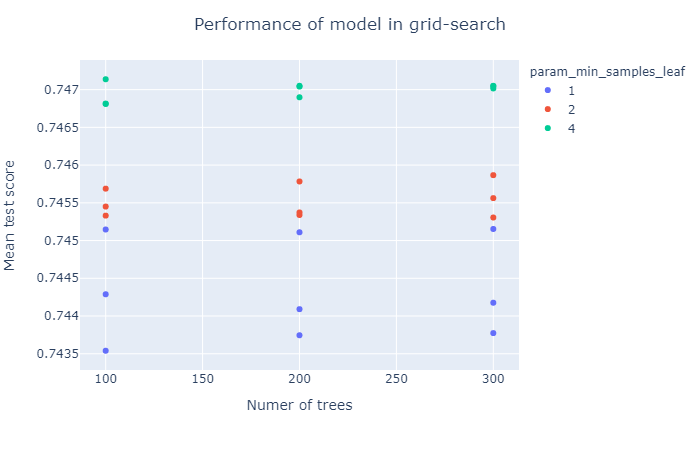

In [33]:
#df_rf = pd.DataFrame(data=grid_cv_model_randomfor.cv_results_)
df_rf = pd.read_csv("gridsearch.csv") 
df_rf= pd.DataFrame(df_rf)

df_rf["param_min_samples_leaf"] = df_rf["param_min_samples_leaf"].astype(str)

fig=px.scatter(df_rf[['mean_test_score',
                           'param_min_samples_leaf',
                           'param_n_estimators', 'param_min_samples_split']],
             y='mean_test_score',x='param_n_estimators',hover_data=['param_min_samples_split'],
             color='param_min_samples_leaf')
fig.update_layout(
    xaxis_title='Numer of trees',yaxis_title="Mean test score",
    title={
        'text': "Performance of model in grid-search",
        'x':.5}
    
)

fig.show("png")

To investigate the model further, the next section will cover feature importance.

#### 3.2.4 Feature Importance

The Random Forest feature importance has been visualized below. The importances sums to 1, so the feature importances can be interpreted as the fraction of the total importance. The most important feature is the hour of the week with an importance of around ~18%. This means, that the model predicts some part of the weeks to have more severe crashes compared to other. It can be seen that the second most important feature is being an occupant, thus being in a car, as it has around ~16% of the total importance. This is in coherrence with the previous findings, which stated that motorist was the most frequent group getting injured, compared to pedestrians and cyclist. It is also noticed that the weather and borough attritbutes has a rather low feature importance, thus being in a particular borough or weather condition, is not predicted to have an effect of being injured or not when being in a crash.

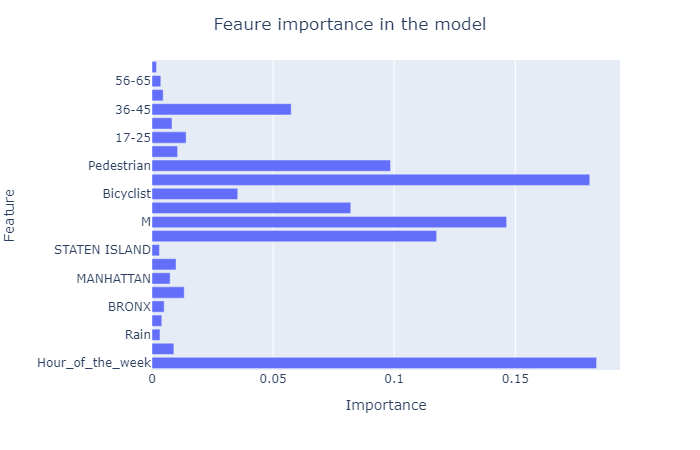

In [34]:
# get importance
importance = model_randomfor.feature_importances_
importance = pd.DataFrame(importance).rename(columns= {0: 'Importance'})
importance=pd.concat([importance.reset_index(drop=True), pd.DataFrame(X_train.columns)], axis=1).rename(columns= {0: 'Feature'})

fig = px.bar(importance,x="Importance",y="Feature",barmode='group',orientation="h")
fig.update_layout(
    title={
        'text': "Feaure importance in the model",
        'x':.5}
    
)
fig.show("png")

#### 3.2.5 Model output
The model output is of course given by the predicted outcome, if the user given in a crash would be 'injured' or 'unharmed'. We have also chosen to display a stacked bar-chart that displays the predictives model's estimated probability of both of the outcomes, which changes dynamcially as the inputs of the model changes. Below an example is shown where the input is: 
- Age: '<16'
- Weather condition: 'fog'
- Borough: 'BROOKLYN'
- Hour-of-the-day: 14
- Day of the week: 'Wednesday'
- Gender: 'Male'
- Mode of transportation: 'Pedestrian'

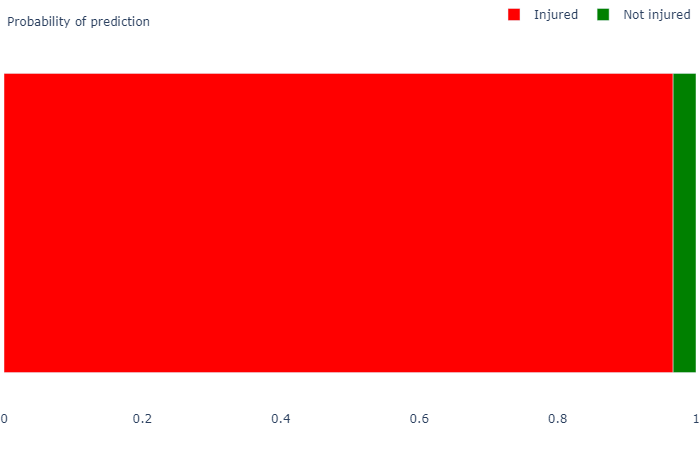

In [35]:
# Building input_interpreter that is used on the website as well. Example here given by:
# '<16','fog','BROOKLYN',14,'Wednesday','Male','Pedestrian'
age_list = ['<16','17-25','26-35','36-45','46-55','56-65','65<']
weekday_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
borough_list = ['QUEENS', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'STATEN ISLAND']
weather_list = ['fog','snow','rain']
transportation_list = ['Pedestrian','Occupant','Bicyclist']
gender_list = ['Male','Female','Undefined']

import joblib
random_forest_model = joblib.load(open('random_forest.pkl', 'rb'))

def input_interpreter(age,weather,borough,hour,day,gender,transportation):
    age_vec = [age==ele for ele in age_list]
    weather_vec = [weather==ele for ele in weather_list]
    borough_vec = [borough==ele for ele in borough_list]
    hour_of_week = [24*weekday_list.index(day)+hour]
    gender_vec = [gender==ele for ele in gender_list]
    transport_vec = [transportation==ele for ele in transportation_list]
    return age_vec + hour_of_week + weather_vec + borough_vec + gender_vec + transport_vec


arr= model_randomfor.predict_proba([input_interpreter('<16','fog','BROOKLYN',14,'Wednesday','Male','Pedestrian')])
arr1=pd.DataFrame(arr)
arr1=arr1.rename(columns = {0: 'Injured', 1: 'Not injured'},index = {0: 'Prediction'})

fig = px.bar(arr1,color_discrete_sequence=["red", "green"],orientation='h',height=100)
fig.update_layout(
    title={'text':"Probability of prediction", 'x': 0.01, 'yanchor':'top'},titlefont_size = 12,
    xaxis={'title': '', 'range': [0, 1]},yaxis={'visible':False},
    paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',
    margin={"l":0,"r":0,"t":5,"b":0},
    legend=dict(title='', orientation="h",
    yanchor="bottom",y=1.02,
    xanchor="right", x=1))
fig.show("png")

## 4. Genre

### 4.1 Genre of data story (narrative visulization)
*Which genre of data story did you use?*

Multiple genres has been made use of in the case of our website. The main one being an interactive slide-show style which the website is build upon. This has been applied by having three distinct tabs on the website; *Front Page*, *Collision maps*, *Predict severity*. Each of the three tabs has their own distinct purpose all being consolidated under the interactive slideshow genre. The main goal here is to create a balanced author-driven and reader-driven story making use of each of their strentghts. More specifically a linear ordering of scenes with addtional auxillary applications such as the interactive heatmap and predictive model. This results in a semi-linear ordering of scenes with the advantages of enabling free interactivity to the users. The three tabs (slides) consists of the following genres:

- **Front Page.** A *magazine* style page introducing the users to the project's story including various line plots with hovering and details on demand.


- **Collision maps.** A *annotated map* page allowing the user to interactively explore the crash patterns of NYC based on time-depended filterings by a slider, zoom functionalities, and details by demand through hovering on the distinct crash-sites. By actively choosing to do so, the user can shift to another interactive map on the same page; Crash/Volume Ratio by Borough, allowing for the same filterings and functionalities as the heat-map. On the bottom and left-side of the page there are bar plots showing relevant information updated by the active filtering as well.


- **Injury severity.** A interactive *comic strip* style page based on the constructed predictive injury severity model. By filling out various drop-down menu's describing user's personal attributes and external conditions, such as time, weather, and location, the user gets to know whether or not the model predicts them to be unharmed or injured the case of them being a victim of a collision. The chart visualized on the bottom of the site dynamically change and displays the model's percentage assesment of the outcame, while a static feature importance chart is also displayed to the right.

### 4.2 Visual narrative tools
*Which tools did you use from each categoriey of Visual Narrative. Why?*

- **Visual structuring**.Firstly, a *consistent visual platform* has been achieved by applying the same color palettes across the same type of plots to create a coherant story with less obscurities. Also, the three different tabs on the website can be considered as a *progress bar* through the narrative story of the website. A *timebar* has also been applied in the shape of a slider on the *annotated map* which allows for intuitive and active filtering
- **Highlightning**. Firstly, *feature distinction* has been applied throughout the various vizualtion, mostly in combination with the consistent visuals of color coding. This allows the user to think less about which features represent what after they have been introduced to for example, the Borough colors in the first place. Also, through geographical shape plottings in the *annotated maps*, the Boroughs are clearly distinctable by their natural borders. *Motion* and *zooming* has been considered in the *annotated maps* to allow the users to actively move and zoom the map-frame to explore the presented data to their own needs.
- **Transition guideline**. *Familiar Objects* are present as a transition guidline in the shape of the three website tabs. Also, drop-down menus have been chosen in the predictive model page as these should also be very familiar and recognizable to users. 

### 4.3 Narrative structure tools
*Which tools did you use from each categoriey of Narrative Structure. Why?*

- **Ordering.** Since we have chosen to go with a balanced author-driven and reader-driven story, the *ordering* of the website can be considered to be a mix of *linear* and *user directed path*. The reasoning for this being, that we have chosen a linear path we recommend the user take by ordering the webside tabs in a certian order. However, the user are not necessarily *forced* to follow this order, and are instead able to follow any *user directed path* they feel like and skip through the tabs freely.
- **Interactivity.** Interactivity has been weighted highly in our project as we think some of the most captivating data stories are achieved by letting the users explore any patterns they'd like within the set boundaries of the chosen data. Therefore, *explicit instructions* are included to guide the user to interact with the interactive elements optimally including *navigation buttons* in the shape of the three distinct tabs at the top of the website. While *stimulating default views* has been chosen for the *Front Page*, a more detailed approach has been applied for the *annotated maps* where *hover highligthting* is available for details on demand on the specific crash sites. By hovering the cursor on the specefic crash sites, the user retrives details in a small pop-up box consisting of: Number of people involved, injured and killed. Here, active *filtering* has also been implemented as a time slider that allows the user to both broaden and narrow their desired overview.
- **Messaging.** The primary method of messaging on our website is through *captions/headlines* to clearly commnicate what is in focus in every part of story. *Annotations* have been included to describe the main take-aways of the static visualizataions on the *Front page*, while they are included on the *Collision heat-map* and *Injury severity* tabs to explain the use of interactive functionalities. A *introductory text* has been written and displayed at the top of the *Front page* to clearly communicate the motivation of the website. And lastly, a short *summary* has been included at the bottom of the *Front page* to display the main findings of story.

## 5. Visualizations
*Explain the visualizations you've chosen. Why are they right for the story you want to tell?*

As explained in the Genre part, our website has a total of three tabs; 
- **Front page.** Including line plots to introduce the user to the key points of data analysis. All visualizations enable hovering with details on demand.


- **Collision maps.** Including 2 different maps which can be switched between with a drop-down menu. The first map is a interactive heat map which displays collision-sites in NYC with hovering details on demand. The second map is a interactive choropleth map which displays each borough's crash/volume ratio. A slider at the bottom of the page allows for active filtering based on the hours-of-the-week. A group of three bar-chart plots are displayed at the right-hand side, and respectively display the fraction of collisions, fraction of traffic volume, and the crash/volume ratio for all five boroughs. At the bottom of the page, a bar-chart displays the crash distributions across the selected filtered hours-of-the-week. All the bar-chart plots change in relation to the active filtering, and allow for hovering and details on demand.


- **Predict injury.** While this page primarly facilitates for the Machine Learning predictive model, it also includes a couple of visuualizations. The first one is stacked bar-chart, which is initally hidden, but then appears after the user have logged in the input for the model. The stacked bar-chart displays the predictives model's estimated probability of both of the outcomes, and changes dynamcially as the inputs of the model changes. The second plot is a simple bar-chart that displays the model's feature importances. Both visualizations allow for hovering and details on demand.

### 5.1 Front page
We have chosen to only include line charts on our front page, as our data is heavily time depended. The main story here is present the user for collision data depended on time, injury severity, demographics (gender and age), boroughs, and of course the crash/volume ratio. Line charts are excelent for visualizing time deppended developments. The story here takes heavy inspiration from the Data Analysis part and includes the following re-used four line plots in the follwing order:

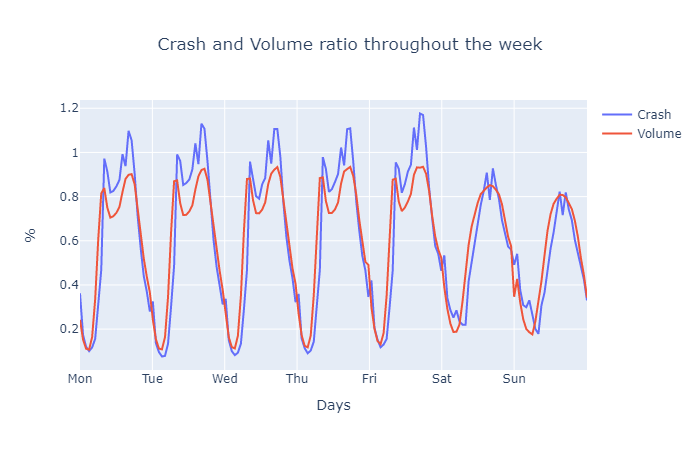

In [36]:
# Plotting traffic and crash percentage over the week

df_ratio['FIPS'] = df_ratio['BOROUGH'].apply(lambda x: '36005' if x == "BRONX" else '36047' if x == "BROOKLYN" else '36061' if x == "MANHATTAN" else  '36081' if x == "QUEENS" else '36085' if x == "STATEN ISLAND" else "No Borough")

weekday=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

percentage_plot= (df_ratio.groupby('hour_of_the_week').sum()*100).reset_index().rename(columns={"Percentage_Crash":"Crash","Percentage_Volume":"Volume"})
fig = px.line(percentage_plot, x="hour_of_the_week", y=["Crash",'Volume'], title="Crash and Volume ratio throughout the week", labels = {"variable":""})
fig.update_layout(
    xaxis = dict(
        tickvals = np.linspace(1,168-24,7),
        ticktext = weekday
    )
    ,xaxis_title='Days',yaxis_title="%",
    title={'x':0.5, 'xanchor': 'center'},
    
    
)
fig.show("png")

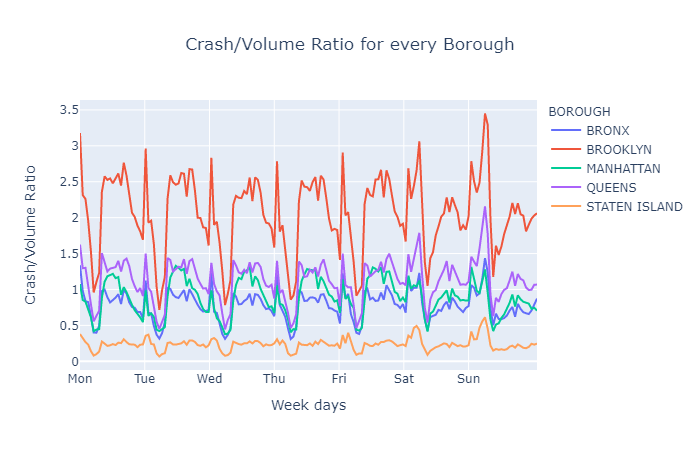

In [37]:
# Plotting crash/ratio for every borough over the week

fig = px.line(df_ratio, x="hour_of_the_week", y="Crash/Volume Ratio", color="BOROUGH", title="Crash/Volume Ratio for every Borough")
fig.update_layout(
    xaxis = dict(
        tickvals = np.linspace(1,167-24,7),
        ticktext = weekday
    )
    ,xaxis_title='Week days',yaxis_title="Crash/Volume Ratio", title={'x':0.5, 'xanchor': 'center'}
)
fig.show("png")

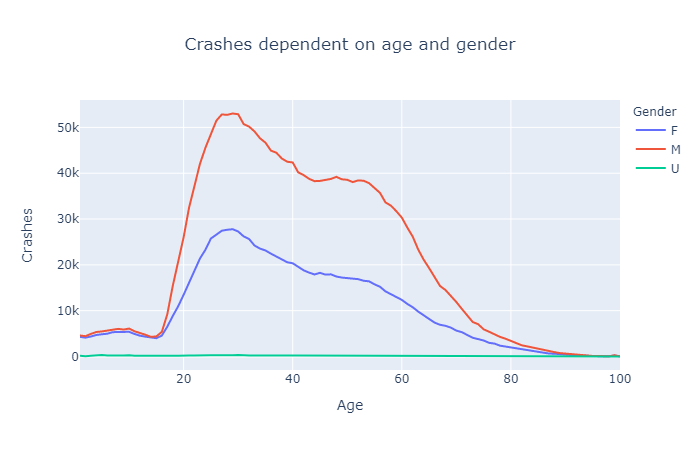

In [38]:
"png"# Plotting the number of crashes for every sex dependent on ange

df_age_sex= df_persons.groupby(['PERSON_AGE','PERSON_SEX']).count().reset_index().rename(columns={'COLLISION_ID': 'Crashes'})

fig = px.line(df_age_sex, x="PERSON_AGE", y="Crashes", color='PERSON_SEX', title="Crashes dependent on age and gender", labels={
                     "PERSON_SEX": "Gender"
                 })

fig.update_layout(
   xaxis_title="Age", title={'x':0.5, 'xanchor': 'center'}
)



fig.show("png")

C:\Users\jonat\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:329: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.


C:\Users\jonat\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




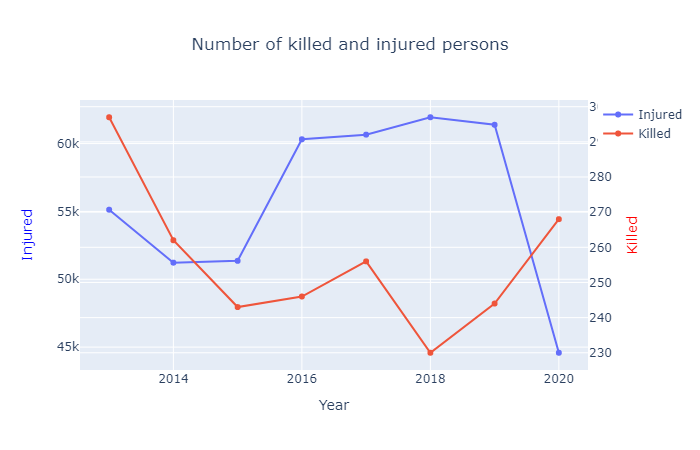

In [39]:
injuryplot=df_describe.groupby('Year').sum().reset_index()[:-1].iloc[1:]

data = [
    go.Scatter(x = injuryplot['Year'], y=injuryplot["NUMBER OF PERSONS INJURED"], name='Injured'),

    go.Scatter(x = injuryplot['Year'], y=injuryplot["NUMBER OF PERSONS KILLED"], name='Killed', 
                yaxis='y2') # binding to the second y axis
]

# settings for the new y axis

y1 = go.YAxis(title='Injured', titlefont=go.Font(color='Blue'))
y2 = go.YAxis(title= 'Killed', titlefont=go.Font(color='Red'))

y2.update(overlaying='y', side='right')
# adding the second y axis
layout = go.Layout(yaxis1 = y1, yaxis2 = y2)

fig = go.Figure(data=data, layout=layout)
fig.update_layout( title={'text':"Number of killed and injured persons",'x':0.5, 'xanchor': 'center'},
                  xaxis_title='Year'
)
fig.show("png")

### 5.2 Collision maps

#### 5.2.1 Collision heat map
This plots aims to geograghically visualize each crash-site by a density heatmap on top of a NYC map. The density of the heat-map changes according to the user's active hours-of-the-week filtering. The map allows for hovering with details on demand and zooming. A group of three bar-chart plots are displayed on the website at the right-hand side, and respectively display the fraction of collisions, fraction of traffic volume, and the crash/volume ratio for all five boroughs. At the bottom of the page, a bar-chart displays the number of crashes across the selected filtered hours-of-the-week. We have chosen to make use of bar charts in this case, as it is and excellent visualization method to display grouped (borough) densities. The map is displayed below,and a .gif below that to show a example of the page in action.

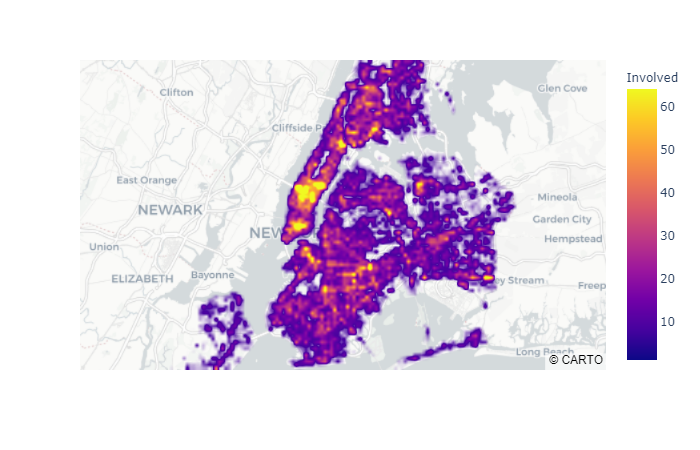

In [40]:
# Making dataframe to plot crashes with hover data

df_crashes = df_crash[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','COLLISION_ID','BOROUGH','Hour_of_the_week','LATITUDE','LONGITUDE','CRASH TIME']]
df_persons_grouped = pd.DataFrame(df_persons['COLLISION_ID'].value_counts(ascending=True)).reset_index().rename(columns={'index': 'COLLISION_ID', 'COLLISION_ID': 'Involved' })
df_crashes_merged = pd.merge(df_crashes, df_persons_grouped,  how='left', left_on=['COLLISION_ID'], right_on = ['COLLISION_ID'])
df_crashes_merged['Injured'] = df_crashes['NUMBER OF PERSONS INJURED']
df_crashes_merged['Killed'] = df_crashes['NUMBER OF PERSONS KILLED']
df_crashes_merged['Killed'] = df_crashes_merged['Killed'].fillna(0)
df_crashes_merged['Injured'] = df_crashes_merged['Injured'].fillna(0)
df_crashes_merged= df_crashes_merged.dropna(subset=['Involved','BOROUGH'])

start_hour = 0
end_hour = 24

# Plotting the crashes with hover data dependent on the span of the hour of the week

df_crashes_merged_plot = df_crashes_merged[(df_crashes_merged['Hour_of_the_week']>start_hour) & (df_crashes_merged['Hour_of_the_week']<end_hour)]

fig = px.density_mapbox(df_crashes_merged_plot,  lat='LATITUDE', lon='LONGITUDE', z='Involved', radius=3,
                        hover_data={'LATITUDE':False,'LONGITUDE':False,'Killed':True,'Injured':True, 'CRASH TIME':True},
                        zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                        mapbox_style="carto-positron")
fig.show("png")

![Movie](https://github.com/edry-edry/02806---Social-data-analysis-and-visualization/blob/main/final_heatmap.gif?raw=true "movie")

#### 5.2.2 Ratio choropleth
This plots aims to geograghically visualize the crash/volume ratios dividied in distinct fips-code areas representing the five boroughs. Each borough is then dynamically colored given by the variable crash/volume ratio depending on the user's chosen hours-of-the-week filtering. The map allows for hovering with details on demand and zooming.  A group of three bar-chart plots are displayed on the website at the right-hand side, and respectively display the fraction of collisions, fraction of traffic volume, and the crash/volume ratio for all five boroughs.At the bottom of the page, a bar-chart displays the number of crashes across the selected filtered hours-of-the-week. The map is displayed below, and if not loaded probably in this notebook, a .gif has been created to display the map in action.

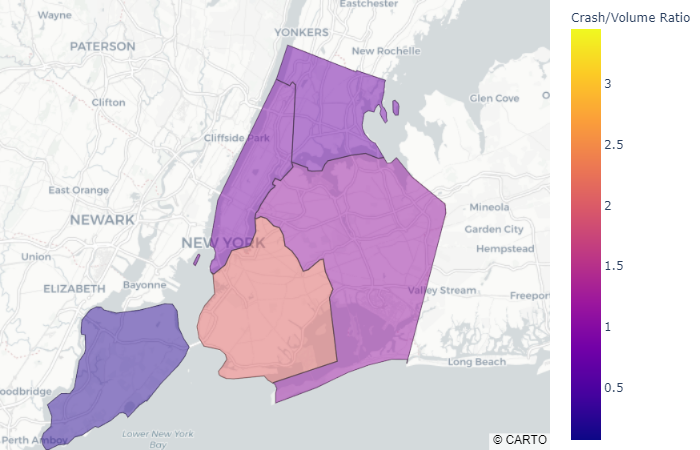

In [41]:
fips_newyork = [36005, 36047, 36061, 36081, 36085]

start_hour = 0
end_hour = 168

# Making the dataframe to plot the crash/volume ratio for every borough dependt on the span of the hour of the week
df_ratios_plot = df_ratio[(df_ratio['hour_of_the_week']>start_hour)&(df_ratio['hour_of_the_week']<end_hour)].groupby("BOROUGH").mean().reset_index()
df_ratios_plot['FIPS'] = df_ratios_plot['BOROUGH'].apply(lambda x: '36005' if x == "BRONX" else '36047' if x == "BROOKLYN" else '36061' if x == "MANHATTAN" else  '36081' if x == "QUEENS" else '36085' if x == "STATEN ISLAND" else "No Borough")

# Plotting the crash/volume ratio for every borough dependt on the span of the hour of the week

fig = px.choropleth_mapbox(df_ratios_plot, geojson=counties, locations='FIPS', color='Crash/Volume Ratio',
                           #color_continuous_scale="Viridis",
                           range_color=(min(df_ratio['Crash/Volume Ratio']),max(df_ratio['Crash/Volume Ratio'])),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.5,
                           hover_data={'FIPS':False,'BOROUGH':True},
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show("png")

![Movie](https://github.com/edry-edry/02806---Social-data-analysis-and-visualization/blob/main/final_borough.gif?raw=true "movie")

### 5.3 Predict injury
Since this tab primarly facilitates for the Machine Learning predictive model, we have chosen to let the user initally focus of the drop-down to log in the input for the model. The tab however includes the following two plots, the first displaying the model's estimated probability of both of the outcomes and the other a bar-chart that displays the model's feature importances. Both visualizations allow for hovering and details on demand. The model to visualization dynamic can be seen in the .gif below.

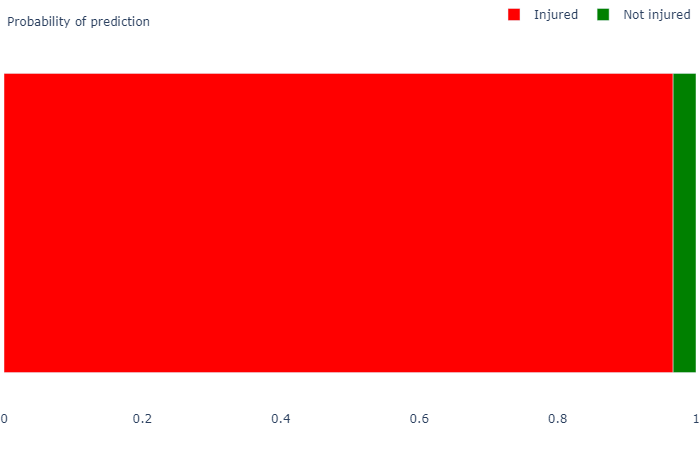

In [42]:
arr= model_randomfor.predict_proba([input_interpreter('<16','fog','BROOKLYN',14,'Wednesday','Male','Pedestrian')])
arr1=pd.DataFrame(arr)
arr1=arr1.rename(columns = {0: 'Injured', 1: 'Not injured'},index = {0: 'Prediction'})

fig = px.bar(arr1,color_discrete_sequence=["red", "green"],orientation='h',height=100)
fig.update_layout(
    title={'text':"Probability of prediction", 'x': 0.01, 'yanchor':'top'},titlefont_size = 12,
    xaxis={'title': '', 'range': [0, 1]},yaxis={'visible':False},
    paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',
    margin={"l":0,"r":0,"t":5,"b":0},
    legend=dict(title='', orientation="h",
    yanchor="bottom",y=1.02,
    xanchor="right", x=1))
fig.show("png")

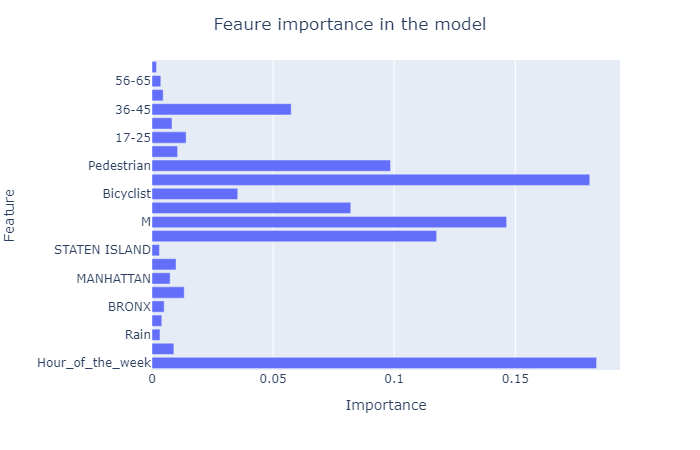

In [43]:
# Get model importance
importance = model_randomfor.feature_importances_
importance = pd.DataFrame(importance).rename(columns= {0: 'Importance'})
importance=pd.concat([importance.reset_index(drop=True), pd.DataFrame(X_train.columns)], axis=1).rename(columns= {0: 'Feature'})

fig = px.bar(importance,x="Importance",y="Feature",barmode='group',orientation="h")
fig.update_layout(
    title={
        'text': "Feaure importance in the model",
        'x':.5}
    
)
fig.show("png")

![Movie](https://github.com/edry-edry/02806---Social-data-analysis-and-visualization/blob/main/final_predict.gif?raw=true "movie")

## 6. Discussion
*Think critically about your creation. What went well? What is still missing? What could be improved? Why?*

### 6.1 Comparing crash data with traffic volume data.
One of the main goals of this project has been to investigate how dangerous the different boroughs are relative to each other. In order to do this, it is necessary to incorporate the traffic volume. The main problem here was, that traffic-volume data was not found available to match the exact date and time frames of the main crash data. Instead, we scaled the traffic volume down to hour of the week. This is considered to be done sucessfully, as the volume ratio follow the crash ratio overall quite well. However, it would have been preferable to have the traffic volume data avialable for all time frames so the two datasets could be merged joined loosing any details on any level of the analysis. For future studies, it could be interesting to include a more detailed daily volume, as this would give more representative results. This would also have allowed for an investigating the crash/volume ratio on a more nuanced level. This could for example be to show how the different months affects the ratio, or if there are more crashes around specific days in the year, for instance around independence day where people are drinking more compared to other days. 

### 6.2 Machine Learning model building. More models?
While we got satisfying results from our created machine learning model, it would still have been interesting to see how other predictive models whould have performed in our predictions. Also, for further research, it would have been interesting to see how the model whould have predicted in the case where we not only balanced our dataset depended on the outcome variable, but also on the features such as; the same amount of age groups, transportation modes, time of the day etc. This whould have allowed us to compare the various model performances, and thus allowing us to freely choose the model which performed the best to our project needs.

### 6.3 Hosting the webstie. Scope and time spent.
We weighted interactability and exploartion very high in our project. Therefore, we invested alot of time into creating various functionalities in our website applications, such as; three distinct tabs, plotly express plots with hovering and details on demand, a time-filtering slider, interactive annotated maps, and a user-friendly predictive model experience. While we are satisfied with the end result, we had some hich-ups along the way. First and foremost, the 500mb storage limit in *Heuroku* showed to be a main obsticable since we had troubles compressing our loaded python packages into reasonable sizes, resulting in most of the data not being able to be loaded. Also, because of out time- AND geo-depended data, the collision heat-map needed a sizeable chunk of space to be run properly showing all the needed patterns. Therefore, we ended up with transfering our whole website to the *Python Anywhere* platform, thus allowing us to execute all of our thought-out application ideas. While this has been a great learning experience, it would have been interesting to see how the project whould have evolved if we scoped down our website, and instead used that time elsewhere, such as in telling new data stories through other addional data sets etc. 

## 7. Contributions

All group members have been equally involved and have had a equally saying in every part of this project. While all group members have contributed equally in the making of the project, the below list simply presents which member had the leading resposibility in the various parts of the project:

- Data cleaning, and preprocessing - *Jonatan*
- Data analysis - *Mikkel, Jonatan & Simon*
- Interactive heatmap and choropleth maps - *Mikkel, Jonatan & Simon*
- Machine Learning - *Mikkel*
- Establishing website, github, and deploying the application - *Simon*
- Explainer notebook - *Mikkel & Jonatan*

## 8. Reference List

- Segel, Edward & Heer, Jeffrey. Narrative Visualization: Telling Stories with Data. 2011. IEEE. DOI: 10.1109/TVCG.2010.179.

- Philipp K. Janert. Data Analysis with Open Source Tools. November 2010. O'Reilly Media, Inc. ISBN: 9780596802356

- Deploy your dash app on Heroku platform. Yu Liang Weng. 3 July 2020. Lastly accessed 14-05-2021. https://dataviz.shef.ac.uk/blog/03/07/2020/Deploy-Your-Dash-App?fbclid=IwAR3YZdlGMFI3UylwK1cGNXmfA31uhs_Vj80JVONQ7lhkiUxf4EuhKlSWSdw

- Deploying your Dash App to Heroku — THE MAGICAL GUIDE. Dan Baker. Nov 23, 2020. Lastly accessed 14-05-2021. https://towardsdatascience.com/deploying-your-dash-app-to-heroku-the-magical-guide-39bd6a0c586c

- Dash Python User Guide. Lastly accessed 14-05-2021. https://dash.plotly.com/

- Choropleth Maps in Python. Lastly accessed 14-05-2021. https://plotly.com/python/choropleth-maps/

- Mapbox Density Heatmap in Python. Lastly accessed 14-05-2021. https://plotly.com/python/mapbox-density-heatmaps/

- Line Plot with plotly.express. Lastly accessed 14-05-2021. https://plotly.com/python/line-charts/?fbclid=IwAR0vTRI8I3r5TJ-XJdZLkyoFPOQk69xZ4CRdL3wTe6XeX_gG-mefI48wAYk

- Bar chart with Plotly Express. Lastly accessed 14-05-2021. https://plotly.com/python/bar-charts/?fbclid=IwAR1mCmiDIG0ZHhKBqvaxbbHzmSg649mDeryACmYPMH7lbVplVVmxvWV17Ks

- NYC OpenData. Motor Vehicle Collisions - Crashes. Lastly accessed 14-05-2021. https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

- NYC OpenData. Motor Vehicle Collisions - Person. Lastly accessed 14-05-2021. https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu

- NYC OpenData. Traffic Volume Counts (2014-2019). Lastly accessed 14-05-2021. https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts-2014-2019-/ertz-hr4r

- National Centers for Environmental Information (NOAA). NYC Weather data. Request ordered 21-04-2021. https://www.ncdc.noaa.gov/cdo-web/datasets#GHCND